In [1]:
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import re
import pickle
import ipywidgets as widgets
from IPython.display import display, clear_output

# Завантаження ресурсів NLTK
nltk.download('punkt')
nltk.download('punkt_tab') # Важливо для нових версій NLTK

# --- ЗАВАНТАЖЕННЯ КОРПУСУ ---
# Збережіть тексти Леся Подерв'янського у файл 'poderviansky.txt'
FILENAME = "poderviansky.txt"

# Демонстраційний текст, якщо файл не знайдено (для перевірки коду)
DEMO_TEXT = """
Гамлет, або Феномен датського кацапізму.
Купатися чи не купатися? Блядські ці питання зайбують.
Митець повинен бути голодним.
Лесь Подерв'янський — геній сучасності.
Сало, горілка, космос.
"""

def load_corpus(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            return f.read()
    except FileNotFoundError:
        print("Файл не знайдено. Використовую демо-текст.")
        return DEMO_TEXT

def tokenize(corpus):
    # Заміна знаків пунктуації на крапки
    data = re.sub(r'[,!?;-]+', '.', corpus)
    # Токенізація
    data = nltk.word_tokenize(data)
    # Нижній регістр + тільки літери (кирилиця)
    # Додаємо перевірку на українські літери
    data = [ch.lower() for ch in data if ch.isalpha() or ch == '.']
    return data

def get_dict(data):
    words = sorted(list(set(data)))
    word2Ind = {word: i for i, word in enumerate(words)}
    Ind2word = {i: word for i, word in enumerate(words)}
    return word2Ind, Ind2word

# Завантаження та обробка
corpus_raw = load_corpus(FILENAME)
words = tokenize(corpus_raw)
word2Ind, Ind2word = get_dict(words)
V = len(word2Ind)

print(f"Кількість слів у корпусі: {len(words)}")
print(f"Розмір словника (V): {V}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Файл не знайдено. Використовую демо-текст.
Кількість слів у корпусі: 32
Розмір словника (V): 23


In [2]:
def get_vectors(data, word2Ind, V, C):
    i = C
    while True:
        y = np.zeros(V)
        x = np.zeros(V)

        center_word = data[i]
        y[word2Ind[center_word]] = 1

        context_words = data[(i - C):i] + data[(i+1):(i+C+1)]
        num_ctx = len(context_words)

        for word in context_words:
            x[word2Ind[word]] += 1 / num_ctx

        yield x, y
        i += 1
        if i >= len(data) - C:
            i = C

def get_batches(data, word2Ind, V, C, batch_size):
    batch_x = []
    batch_y = []
    for x, y in get_vectors(data, word2Ind, V, C):
        batch_x.append(x)
        batch_y.append(y)
        if len(batch_x) == batch_size:
            yield np.array(batch_x).T, np.array(batch_y).T
            batch_x = []
            batch_y = []

# --- MODEL FUNCTIONS ---

def softmax(z):
    e_z = np.exp(z - np.max(z, axis=0, keepdims=True)) # Стабільний softmax
    return e_z / np.sum(e_z, axis=0)

def initialize_model(N, V):
    np.random.seed(42)
    W1 = np.random.rand(N, V)
    W2 = np.random.rand(V, N)
    b1 = np.random.rand(N, 1)
    b2 = np.random.rand(V, 1)
    return W1, W2, b1, b2

def forward_prop(x, W1, W2, b1, b2):
    h = np.dot(W1, x) + b1
    h = np.maximum(0, h) # ReLU
    z = np.dot(W2, h) + b2
    return z, h

def back_prop(x, yhat, y, h, W1, W2, b1, b2, batch_size):
    z1 = np.dot(W1, x) + b1
    l1 = np.dot(W2.T, yhat - y)
    l1[z1 < 0] = 0 # ReLU derivative

    grad_W1 = np.dot(l1, x.T) / batch_size
    grad_W2 = np.dot(yhat - y, h.T) / batch_size
    grad_b1 = np.sum(l1, axis=1, keepdims=True) / batch_size
    grad_b2 = np.sum(yhat - y, axis=1, keepdims=True) / batch_size

    return grad_W1, grad_W2, grad_b1, grad_b2

def compute_cost(y, yhat, batch_size):
    logprobs = np.multiply(np.log(yhat + 1e-9), y) # +epsilon для стабільності
    cost = - 1/batch_size * np.sum(logprobs)
    return np.squeeze(cost)

In [3]:
def gradient_descent(data, word2Ind, N, V, num_iters, alpha=0.03, batch_size=128, C=2):
    W1, W2, b1, b2 = initialize_model(N, V)
    iters = 0

    # Створюємо генератор
    batch_gen = get_batches(data, word2Ind, V, C, batch_size)

    for i in range(num_iters):
        try:
            x, y = next(batch_gen)
        except StopIteration:
            batch_gen = get_batches(data, word2Ind, V, C, batch_size)
            x, y = next(batch_gen)

        z, h = forward_prop(x, W1, W2, b1, b2)
        yhat = softmax(z)
        cost = compute_cost(y, yhat, batch_size)

        if (i+1) % 50 == 0:
            print(f"Ітерація: {i + 1}, Cost: {cost:.6f}")

        grad_W1, grad_W2, grad_b1, grad_b2 = back_prop(x, yhat, y, h, W1, W2, b1, b2, batch_size)

        W1 -= alpha * grad_W1
        W2 -= alpha * grad_W2
        b1 -= alpha * grad_b1
        b2 -= alpha * grad_b2

        if (i+1) % 100 == 0:
            alpha *= 0.95 # Decay

    return W1, W2, b1, b2

# --- ЗАПУСК НАВЧАННЯ ---
C = 2
N = 50
BATCH_SIZE = 64
ITERS = 500
ALPHA = 0.05

print("Початок навчання...")
W1, W2, b1, b2 = gradient_descent(words, word2Ind, N, V, ITERS, ALPHA, BATCH_SIZE, C)
word_embeddings = (W1.T + W2) / 2.0
print("Навчання завершено.")

# Збереження
embeddings_dict = {word: word_embeddings[word2Ind[word]] for word in word2Ind}
with open('les_embeddings.pkl', 'wb') as f:
    pickle.dump({'embeddings': embeddings_dict, 'w2i': word2Ind}, f)

Початок навчання...
Ітерація: 50, Cost: 2.775162
Ітерація: 100, Cost: 2.614155
Ітерація: 150, Cost: 2.488360
Ітерація: 200, Cost: 2.419732
Ітерація: 250, Cost: 2.279367
Ітерація: 300, Cost: 2.203344
Ітерація: 350, Cost: 2.094226
Ітерація: 400, Cost: 2.036188
Ітерація: 450, Cost: 1.938532
Ітерація: 500, Cost: 1.839015
Навчання завершено.


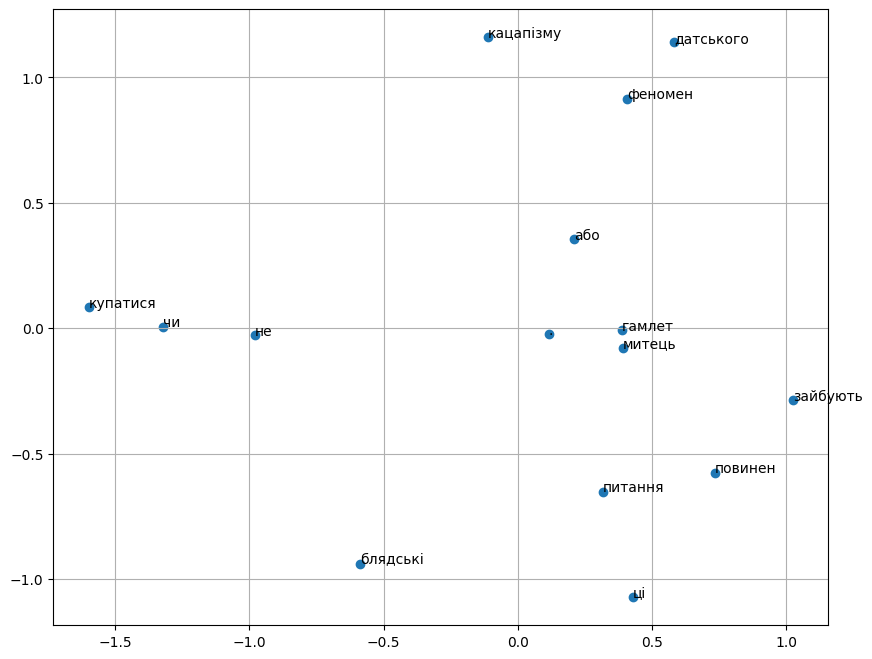

In [4]:
# --- PCA ---
def compute_pca(X, n_components=2):
    X_centered = X - np.mean(X, axis=0)
    cov_matrix = np.cov(X_centered, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    idx = np.argsort(eigenvalues)[::-1]
    eigenvectors = eigenvectors[:, idx]
    eigenvectors = eigenvectors[:, :n_components]
    return np.dot(X_centered, eigenvectors)

# --- UI ---
def create_ui(embeddings_dict):
    word_input = widgets.Text(description='Слово:', placeholder='Наприклад: гамлет')
    btn_find = widgets.Button(description='Знайти схожі')
    out = widgets.Output()

    def cosine_sim(v1, v2):
        return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

    def on_click(b):
        with out:
            clear_output()
            word = word_input.value.strip().lower()
            if word not in embeddings_dict:
                print("Слово не знайдено.")
                return

            vec = embeddings_dict[word]
            sims = []
            for w, v in embeddings_dict.items():
                if w != word:
                    sims.append((w, cosine_sim(vec, v)))

            sims.sort(key=lambda x: x[1], reverse=True)
            print(f"Схожі до '{word}':")
            for w, s in sims[:5]:
                print(f"{w}: {s:.4f}")

    btn_find.on_click(on_click)
    display(widgets.VBox([word_input, btn_find, out]))

# Запуск UI
create_ui(embeddings_dict)

# --- ВІЗУАЛІЗАЦІЯ (TOP WORDS) ---
def plot_embeddings(embeddings_dict, words_to_plot):
    valid_words = [w for w in words_to_plot if w in embeddings_dict]
    if not valid_words: return

    X = np.array([embeddings_dict[w] for w in valid_words])
    pca_res = compute_pca(X)

    plt.figure(figsize=(10, 8))
    plt.scatter(pca_res[:, 0], pca_res[:, 1])
    for i, word in enumerate(valid_words):
        plt.annotate(word, xy=(pca_res[i, 0], pca_res[i, 1]))
    plt.grid()
    plt.show()

# Спробуємо візуалізувати найчастіші слова
common_words = [w[0] for w in Counter(words).most_common(15) if w != '.']
plot_embeddings(embeddings_dict, common_words)